# Coursea IBM Data Science Capstone Project

This will be a notebook for the Coursea IBM Data Science Capston Project.

### first import the needed packages

In [150]:
import numpy as np
import pandas as pd

import requests
import json
import lxml.html as lh
import re

import geocoder 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
print('all packages loaded!')

all packages loaded!


### let's read Wiki page with lxml

In [2]:
#Create a handle, page, to handle the contents of the website
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Store the contents of the website under doc
page = requests.get(url)

#Parse data that are stored between <tr>..</tr> of HTML
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')

### format the data

In [3]:
#Create empty lists
post_code= []
neighb   = []
borough  = []

#crate regex pattern
pattern=re.compile('[M][0-9][A-Z]', flags=0)

#For each row, screen the text and sore it in name and remove linebreaks and empty elements
for t in tr_elements[:]:
    
    name=t.text_content()
    name1 = str.split(name,'\n')
    name1 = list(filter(None, name1))
   
    
#for each element meeting the requirement of the regular expression (post code) extract the post_code the neighborhood and the borough
    for item in name1:
        if re.match(pattern, item[:3]):
            post_code.append(item[:3])
            if item.find('(') == -1:
                neighb.append(item[3:])
                borough.append(item[3:])
            else:  
                neighb.append(item[item.find("(")+1:item.find(")")])
                borough.append(item[3:item.find("(")])

### create a dataframe and read in the data from the table

In [95]:
# define the dataframe columns
column_names = ['PostalCode','Borough', 'Neighborhood'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#populate datafram

for idx, data in enumerate(post_code):
    neighborhoods = neighborhoods.append({'PostalCode':post_code[idx],
                                          'Borough': borough[idx],
                                          'Neighborhood': neighb[idx]},ignore_index=True)
   
# remove rows with not assigned post_codes 
# i change the name of the data frame cince i will later break it down to the neighborhoods
Borough = neighborhoods[neighborhoods['Borough'] != 'Not assigned'].reset_index(drop=True)
#change / seperator to ,
Borough['Neighborhood'] = Borough['Neighborhood'].str.replace(" / ",", ").reset_index(drop=True)


# The resulting Datafram

In [96]:
Borough.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [70]:
Borough.shape

(103, 3)

#### now find the coordinates of each borogh

In [77]:
# initialize your variable to None
latitude_borogh =[]
longitude_borogh=[]

for row in zip(Borough['PostalCode'],Borough['Borough'],Borough['Neighborhood']):
    Lokation = row[0]+' '+row[1]+' '+row[2]
    print(Lokation)
    lat_lng_coords = None
    i=0
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(Lokation)) #arcgis worked!!
        print(i,g)
        lat_lng_coords = g.latlng
        i+=1

    latitude_borogh.append(lat_lng_coords[0])
    longitude_borogh.append(lat_lng_coords[1])

M3A North York Parkwoods
0 <[OK] Arcgis - Geocode [M3A]>
M4A North York Victoria Village
0 <[OK] Arcgis - Geocode [M4A]>
M5A Downtown Toronto Regent Park, Harbourfront
0 <[OK] Arcgis - Geocode [Regent Park, Toronto, Ontario]>
M6A North York Lawrence Manor, Lawrence Heights
0 <[OK] Arcgis - Geocode [M6A]>
M7A Queen's Park Ontario Provincial Government
0 <[OK] Arcgis - Geocode [7 Queens Dr, York, Toronto, Ontario, M9N 2H3]>
M9A Etobicoke Islington Avenue
0 <[OK] Arcgis - Geocode [Islington Ave, Etobicoke, Toronto, Ontario, M9V 2X6]>
M1B Scarborough Malvern, Rouge
0 <[OK] Arcgis - Geocode [M1B]>
M3B North York Don Mills
0 <[OK] Arcgis - Geocode [M3B]>
M4B East York Parkview Hill, Woodbine Gardens
0 <[OK] Arcgis - Geocode [M4B]>
M5B Downtown Toronto Garden District, Ryerson
0 <[OK] Arcgis - Geocode [M5B]>
M6B North York Glencairn
0 <[OK] Arcgis - Geocode [M6B]>
M9B Etobicoke West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
0 <[OK] Arcgis - Geocode [M9B]>
M1C Scarborou

#### check the size

In [78]:
print(len(latitude_borogh),len(longitude_borogh))

103 103


#### append the coordinates to the datafram borogh

In [80]:
Borough['Latitude'] = latitude_borogh
Borough['Longitude'] = longitude_borogh


#  The nighborhood table with coordinates

In [81]:
Borough.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.66069,-79.36031
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Queen's Park,Ontario Provincial Government,43.70357,-79.51672


## lets break the list down on Neighborhoods

In [6]:
#split the Neighborhoods
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].str.split(", ")

In [7]:
#explode the dataframe to have a row for each neighborhood
df = neighborhoods
df=df.explode('Neighborhood').reset_index(drop=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M5A,Downtown Toronto,Harbourfront
4,M6A,North York,Lawrence Manor


#### get the coordinates for every neighborhood

In [74]:
# initialize your variable to None
latitude =[]
longitude=[]

for row in zip(df['PostalCode'],df['Borough'],df['Neighborhood']):
    Lokation = row[0]+' '+row[1]+' '+row[2]
    print(Lokation)
    lat_lng_coords = None
    i=0
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(Lokation)) #arcgis worked!!
        print(i,g)
        lat_lng_coords = g.latlng
        i+=1

    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])


M3A North York Parkwoods
0 <[OK] Arcgis - Geocode [M3A]>
M4A North York Victoria Village
0 <[OK] Arcgis - Geocode [M4A]>
M5A Downtown Toronto Regent Park
0 <[OK] Arcgis - Geocode [Regent Park, Toronto, Ontario]>
M5A Downtown Toronto Harbourfront
0 <[OK] Arcgis - Geocode [M5A]>
M6A North York Lawrence Manor
0 <[OK] Arcgis - Geocode [Lawrence Manor, North York, Toronto, Ontario]>
M6A North York Lawrence Heights
0 <[OK] Arcgis - Geocode [Lawrence Heights, North York, Toronto, Ontario]>
M7A Queen's Park Ontario Provincial Government
0 <[OK] Arcgis - Geocode [7 Queens Dr, York, Toronto, Ontario, M9N 2H3]>
M9A Etobicoke Islington Avenue
0 <[OK] Arcgis - Geocode [Islington Ave, Etobicoke, Toronto, Ontario, M9V 2X6]>
M1B Scarborough Malvern
0 <[OK] Arcgis - Geocode [M1B]>
M1B Scarborough Rouge
0 <[OK] Arcgis - Geocode [M1B]>
M3B North York Don Mills
0 <[OK] Arcgis - Geocode [M3B]>
M4B East York Parkview Hill
0 <[OK] Arcgis - Geocode [Parkview Hill, East York, Toronto, Ontario]>
M4B East York W

#### check the legth:

In [9]:
print(len(latitude_borogh),len(longitude_borogh))

216 216


#### append the coordinates to the Dataframe

In [10]:
#append the coordiantes
df['Latitude'] = latitude
df['Longitude'] = longitude
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,Regent Park,43.66069,-79.36031
3,M5A,Downtown Toronto,Harbourfront,43.65512,-79.36264
4,M6A,North York,Lawrence Manor,43.72294,-79.43116


## ok lets have a look on the spatial distribution


In [11]:
g = geocoder.arcgis('Toronto, Ontario')
t_latitude=lat_lng_coords[0]
t_longitude=lat_lng_coords[1]

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# add markers to map
for lat, lng, Neighborhood, Borough, PostalCode in zip(df['Latitude'], df['Longitude'], df['PostalCode'], df['Borough'],df['Neighborhood']):
    label = '{}, {}'.format(PostalCode, Borough, Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# now lets get the venue data for each neighborhood
<br>
first the credentials

In [237]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### now we define a function to get every venue in the vecinity of our neighberhoods from Foursquare

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### lets get the data

In [14]:
# get info
Toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park
Harbourfront
Lawrence Manor
Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern
Rouge
Don Mills
Parkview Hill
Woodbine Gardens
Garden District
Ryerson
Glencairn
West Deane Park
Princess Gardens
Martin Grove
Islington
Cloverdale
Rouge Hill
Port Union
Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate
Bloordale Gardens
Old Burnhamthorpe
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Wilson Heights
Downsview North
Thorncliffe Park
Richmond
Adelaide
King
Dufferin
Dovercourt Village
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
The Danforth  East
Harbourfront East
Union Station
Toronto Islands
Little Portugal
Trinity
Kennedy Park
Ionview
East Birchmount Park
Bayview Village
Downsview
The Danforth West
Riverdale
Toronto Dominion Centre
Design

### Let's check the size of the resulting dataframe

In [15]:
print(Toronto_venues.shape)
Toronto_venues.head()

(4284, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.75245,-79.32991,TTC stop #8380,43.752672,-79.326351,Bus Stop
3,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
4,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store


In [16]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,37,37,37,37,37,37
Agincourt,13,13,13,13,13,13
Agincourt North,2,2,2,2,2,2
Albion Gardens,14,14,14,14,14,14
Alderwood,4,4,4,4,4,4
...,...,...,...,...,...,...
Woodbine Heights,15,15,15,15,15,15
York Mills,1,1,1,1,1,1
York Mills West,4,4,4,4,4,4


### Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 286 uniques categories.


## Analyze Each Neighborhood

In [18]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Toronto_onehot.shape

(4284, 286)

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agincourt North,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Albion Gardens,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alderwood,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,Woodbine Heights,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,York Mills,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,York Mills West,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,York University,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [21]:
Toronto_grouped.shape

(206, 286)

## Let's print each neighborhood along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                venue  freq
0         Coffee Shop  0.16
1  Italian Restaurant  0.05
2              Bakery  0.05
3             Theater  0.05
4      Breakfast Spot  0.05


----Agincourt----
                venue  freq
0  Chinese Restaurant  0.15
1     Badminton Court  0.08
2       Shopping Mall  0.08
3    Sushi Restaurant  0.08
4         Supermarket  0.08


----Agincourt North----
               venue  freq
0           Pharmacy   0.5
1       Intersection   0.5
2        Yoga Studio   0.0
3  Mobile Phone Shop   0.0
4             Museum   0.0


----Albion Gardens----
           venue  freq
0  Grocery Store  0.14
1    Pizza Place  0.07
2    Auto Garage  0.07
3           Park  0.07
4    Coffee Shop  0.07


----Alderwood----
                venue  freq
0  Athletics & Sports  0.25
1   Convenience Store  0.25
2                 Gym  0.25
3                 Pub  0.25
4         Yoga Studio  0.00


----Bathurst Manor----
               venue  freq
0        Men's Store   1.0
1        

## Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [124]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [125]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Breakfast Spot,Italian Restaurant,Theater,Bakery,Yoga Studio,Cosmetics Shop,Spa,Skating Rink,Sandwich Place
1,Agincourt,Chinese Restaurant,Hong Kong Restaurant,Discount Store,Badminton Court,Supermarket,Department Store,Bubble Tea Shop,Sushi Restaurant,Bakery,Grocery Store
2,Agincourt North,Pharmacy,Intersection,Event Space,Ethiopian Restaurant,Escape Room,Elementary School,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop
3,Albion Gardens,Grocery Store,Pharmacy,Caribbean Restaurant,Liquor Store,Park,Fast Food Restaurant,Beer Store,Sandwich Place,Discount Store,Auto Garage
4,Alderwood,Athletics & Sports,Gym,Pub,Convenience Store,Women's Store,Donut Shop,Distribution Center,Dive Bar,Doctor's Office,Dog Run


In [126]:
Toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Adelaide,0.027027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Agincourt North,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Albion Gardens,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alderwood,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

[[ 3  0]
 [33  1]
 [ 3  2]
 [ 1  3]
 [ 2  4]
 [ 2  5]
 [ 5  6]
 [ 8  7]
 [ 2  8]
 [ 4  9]
 [ 3 10]
 [ 2 11]
 [11 12]
 [ 3 13]
 [13 14]
 [ 4 15]
 [98 16]
 [ 5 17]
 [ 3 18]
 [ 1 19]]


<BarContainer object of 20 artists>

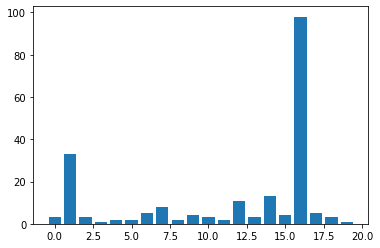

In [235]:
# set number of clusters
kclusters = 20

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

#and occurence
unique, counts = np.unique(kmeans.labels_, return_counts=True)

#check the occurence for each cluster
A=np.asarray((counts, unique)).T
X=A[:,1]
Y=A[:,0]
print(A)


plt.bar(X,Y,align='center')
 

             

the main cluster aer nr: 16, 1,  14 and 12

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [128]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#print(neighborhoods_venues_sorted)

#df is the data frame contaning the information on every single neighberhood
Toronto_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged = Toronto_merged.dropna()
Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].astype('int')
Toronto_merged.head() # check the last columns

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,1,Bus Stop,Food & Drink Shop,Park,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Women's Store
1,M4A,North York,Victoria Village,43.73057,-79.31306,1,German Restaurant,Park,Grocery Store,Women's Store,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant
2,M5A,Downtown Toronto,Regent Park,43.66069,-79.36031,16,Coffee Shop,Thai Restaurant,Restaurant,Grocery Store,Fast Food Restaurant,Beer Store,Pub,Intersection,Indian Restaurant,Sushi Restaurant
3,M5A,Downtown Toronto,Harbourfront,43.65512,-79.36264,16,Coffee Shop,Breakfast Spot,Yoga Studio,Thai Restaurant,Greek Restaurant,Health Food Store,Italian Restaurant,Food Truck,Event Space,Electronics Store
4,M6A,North York,Lawrence Manor,43.72294,-79.43116,16,Pizza Place,Department Store,Liquor Store,Bank,Supermarket,Mexican Restaurant,Bus Line,Doctor's Office,Kids Store,Bagel Shop


Finally, let's visualize the resulting clusters

In [129]:
# create map
map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, bourgh in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels'], Toronto_merged['Borough']):
    label = folium.Popup(str(poi) + ', ' +str(bourgh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


# evaluate some cluster

### cluster 16 has the highest amount of menbers:

In [143]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 16, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].describe(include = 'object')

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,106,106,106,106,106,106,106,106,106,106,106
unique,13,30,36,35,49,51,48,51,48,50,50
top,Downtown Toronto,Coffee Shop,Coffee Shop,Café,Restaurant,Gym,Sandwich Place,Japanese Restaurant,Fish & Chips Shop,Doctor's Office,Coffee Shop
freq,34,35,23,12,10,6,7,8,7,6,7


#### most common for this cluster seems to be coffee shops and restaurant
maybe buissnes are?

### cluster 2 has the second highest amount of members:

In [144]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].describe(include = 'object')

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,33,33,33,33,33,33,33,33,33,33,33
unique,8,14,11,16,18,16,15,16,14,13,14
top,Etobicoke,Grocery Store,Pharmacy,Caribbean Restaurant,Liquor Store,Park,Fast Food Restaurant,Beer Store,Sandwich Place,Discount Store,Auto Garage
freq,16,9,9,8,8,9,9,8,8,8,8


#### most common for this cluster seems to be Grocery Stores, Pharmacy, Liquor Store
maybe living area are?

### cluster 14 has the third highest amount of members:

In [145]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 14, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].describe(include = 'object')

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,13,13,13,13,13,13,13,13,13,13,13
unique,3,2,4,4,4,4,4,4,4,4,4
top,Central Toronto,Park,Convenience Store,Dumpling Restaurant,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Women's Store
freq,9,12,9,9,9,9,9,9,9,9,9


### cluster 12 has the forth highest amount of members:


In [236]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 12, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]].head().describe(include = 'object')

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,5,5,5,5,5,5,5,5,5,5,5
unique,3,4,3,3,4,3,3,4,4,4,4
top,Etobicoke,Flower Shop,Fast Food Restaurant,Playground,Bank,Women's Store,Doner Restaurant,Park,Ethiopian Restaurant,Escape Room,Elementary School
freq,3,2,3,2,2,2,2,2,2,2,2
